### Model Objectives

1. Membangun Model Embedding Berbasis Neural Network
- Mengembangkan model neural network dengan arsitektur dense layers dan dropout untuk mengubah input skor RIASEC (6 dimensi) menjadi vektor embedding berdimensi 16.
- Model disimpan ke dalam file embedding_model.h5 untuk digunakan lebih lanjut.

2. Melakukan Triplet Sampling untuk Pelatihan Embedding

- Membuat data triplet (anchor, positive, negative) berdasarkan kedekatan skor RIASEC menggunakan jarak Euclidean.
- Positive dipilih jika jarak < 1.0, dan negative jika jarak > 2.0.

3. Melatih Model Menggunakan Triplet Loss
- Mengimplementasikan triplet loss dengan margin untuk mendorong embedding anchor lebih dekat ke positive daripada ke negative.
- Melatih model triplet dengan 20 epoch, dan memantau training & validation loss untuk mengevaluasi proses pembelajaran.

4. Menyediakan Representasi Vektor Kepribadian
- Embedding hasil pelatihan dapat digunakan untuk aplikasi lanjutan seperti:
- Visualisasi dengan t-SNE atau UMAP
- Klasifikasi atau clustering pengguna berdasarkan kepribadian
- Rekomendasi pekerjaan berbasis kemiripan vektor (cosine similarity atau KNN)
- Visualisasi Proses Pelatihan
- Menyediakan grafik training dan validation loss untuk mengevaluasi konvergensi model selama proses pelatihan.



## Data Understanding

In [1]:
#Libarary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
dir_riasec= "Dataset/interests_riasec_dataset.csv"
riasec_df = pd.read_csv(dir_riasec)
riasec_df.head()

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,Date,Domain Source
0,11-1011.00,Chief Executives,1.B.1.a,Realistic,OI,Occupational Interests,1.30,11/2023,Machine Learning
1,11-1011.00,Chief Executives,1.B.1.b,Investigative,OI,Occupational Interests,3.24,11/2023,Machine Learning
2,11-1011.00,Chief Executives,1.B.1.c,Artistic,OI,Occupational Interests,2.08,11/2023,Machine Learning
3,11-1011.00,Chief Executives,1.B.1.d,Social,OI,Occupational Interests,3.52,11/2023,Machine Learning
4,11-1011.00,Chief Executives,1.B.1.e,Enterprising,OI,Occupational Interests,6.88,11/2023,Machine Learning


Penjelasan setiap kolom
- O*NET-SOC Code	: Kode unik untuk setiap pekerjaan berdasarkan O*NET (misal: 15-1121.00 untuk "Software Developer"). Ini penting untuk join dengan data pekerjaan lainnya.

- Title	: Nama atau judul dari pekerjaan tersebut (misal: "Software Developers, Applications").

- Element ID	: Kode ID unik untuk elemen tertentu dari pekerjaan, misalnya untuk minat, kemampuan, atau nilai tertentu.

- Element Name	: Nama dari elemen yang sedang dijelaskan, contoh: "Artistic", "Investigative", "Realistic", dsb. Ini adalah bagian dari RIASEC.

- Scale ID	: Kode skala yang digunakan, biasanya menentukan jenis data yang ditampilkan. Contoh: IM (Interest Measure).

- Scale Name	Nama skala, seperti "Importance", "Level", atau lainnya – menjelaskan jenis pengukuran nilai dari elemen tersebut.

- Data Value :	Nilai dari elemen yang diukur, misalnya: seberapa penting Artistic bagi pekerjaan itu, dalam skala tertentu (biasanya 0–100).

- Date	Tanggal data terakhir diperbarui. Bisa digunakan untuk cek keaktualan data.

- Domain Source	Sumber domain data – kadang menyebutkan apakah data ini berasal dari survei incumbent, expert rating, dsb.

Filter dataset riasec hanya menyisakan kolom yang akan digunakan yaitu kolom
- O*NET-SOC Code
- Title
- Element Name
- Data Value

In [3]:
riasec_df = riasec_df [['O*NET-SOC Code', 'Title', 'Element Name', 'Data Value']]
riasec_df

,O*NET-SOC Code,Title,Element Name,Data Value
0,11-1011.00,Chief Executives,Realistic,1.30
1,11-1011.00,Chief Executives,Investigative,3.24
2,11-1011.00,Chief Executives,Artistic,2.08
3,11-1011.00,Chief Executives,Social,3.52
4,11-1011.00,Chief Executives,Enterprising,6.88
...,...,...,...,...
8302,53-7121.00,"Tank Car, Truck, and Ship Loaders",Enterprising,1.31
8303,53-7121.00,"Tank Car, Truck, and Ship Loaders",Conventional,4.68
8304,53-7121.00,"Tank Car, Truck, and Ship Loaders",First Interest High-Point,1.00
8305,53-7121.00,"Tank Car, Truck, and Ship Loaders",Second Interest High-Point,6.00


In [4]:
dir_occupation = "Dataset/occupation_dataset.csv"
occupation_df = pd.read_csv(dir_occupation)
occupation_df.head()

,Code,Occupation,Job Family
0,13-2011.00,Accountants and Auditors \r\nBright Outlook,Business and Financial Operations
1,27-2011.00,Actors,"Arts, Design, Entertainment, Sports, and Media"
2,15-2011.00,Actuaries,Computer and Mathematical
3,29-1291.00,Acupuncturists,Healthcare Practitioners and Technical
4,29-1141.01,Acute Care Nurses,Healthcare Practitioners and Technical


Penjelasan Dataset occupation : 

- Code	: kode standar O*NET-SOC (Occupational Information Network - Standard Occupational Classification) untuk setiap jenis pekerjaan. 
- Occupation	: Nama atau judul pekerjaan. 
- Job Family	: Kategori atau kelompok pekerjaan berdasarkan bidang atau fungsi pekerjaan. 

In [5]:
# Rename nama kolom 'Code' namanya seragam
occupation_df = occupation_df.rename(columns={'Code': 'O*NET-SOC Code'})

## Exploratory Data Analysis

In [6]:
#Variable riasec
riasec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8307 entries, 0 to 8306
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   O*NET-SOC Code  8307 non-null   object 
 1   Title           8307 non-null   object 
 2   Element Name    8307 non-null   object 
 3   Data Value      8307 non-null   float64
dtypes: float64(1), object(3)
memory usage: 259.7+ KB


In [7]:
print("Jumlah pekerjaan :", riasec_df['O*NET-SOC Code'].nunique())
print("Jenis elemen RIASEC:", riasec_df['Element Name'].unique())

Jumlah pekerjaan : 923
Jenis elemen RIASEC: ['Realistic' 'Investigative' 'Artistic' 'Social' 'Enterprising'
 'Conventional' 'First Interest High-Point' 'Second Interest High-Point'
 'Third Interest High-Point']


In [8]:
print("Distribusi elemen RIASEC:")
print(riasec_df['Element Name'].value_counts())

Distribusi elemen RIASEC:
Element Name
Realistic                     923
Investigative                 923
Artistic                      923
Social                        923
Enterprising                  923
Conventional                  923
First Interest High-Point     923
Second Interest High-Point    923
Third Interest High-Point     923
Name: count, dtype: int64


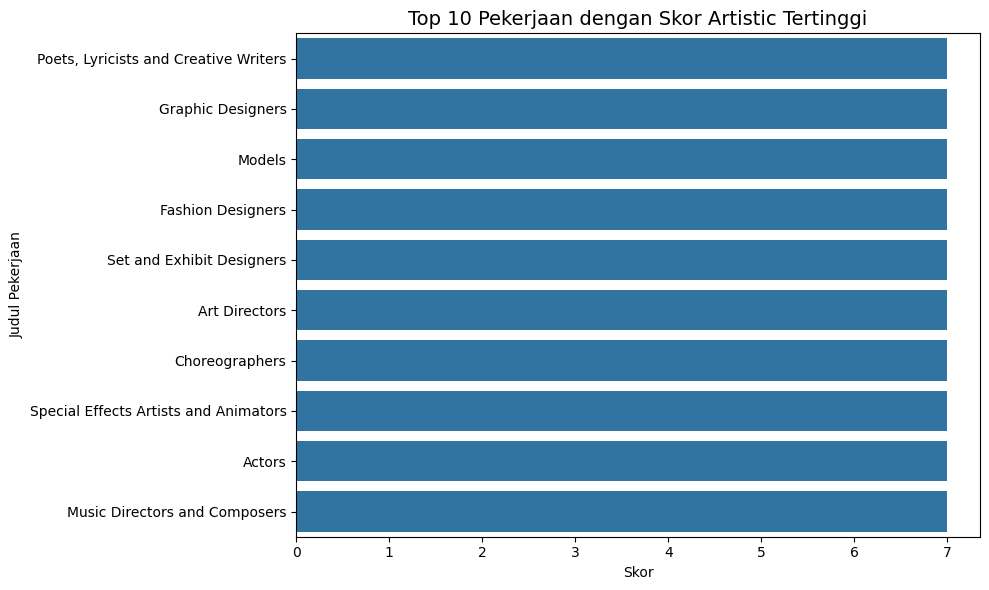

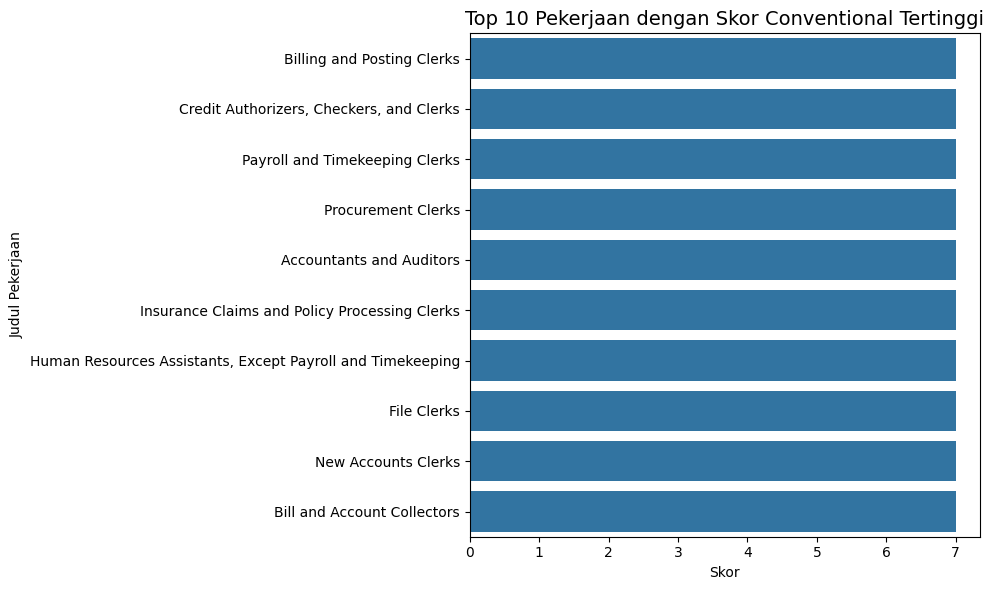

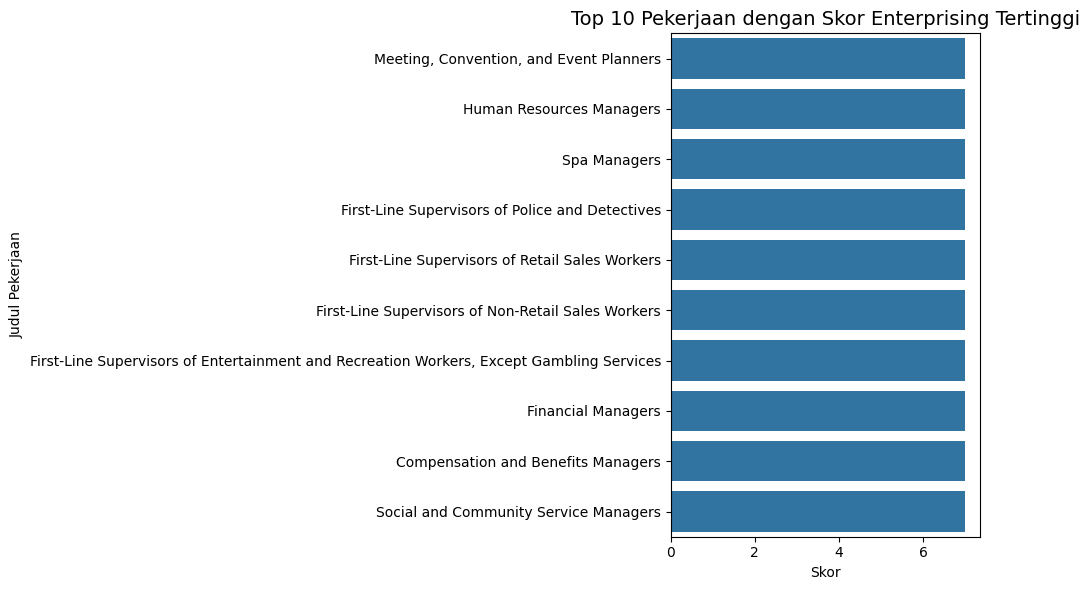

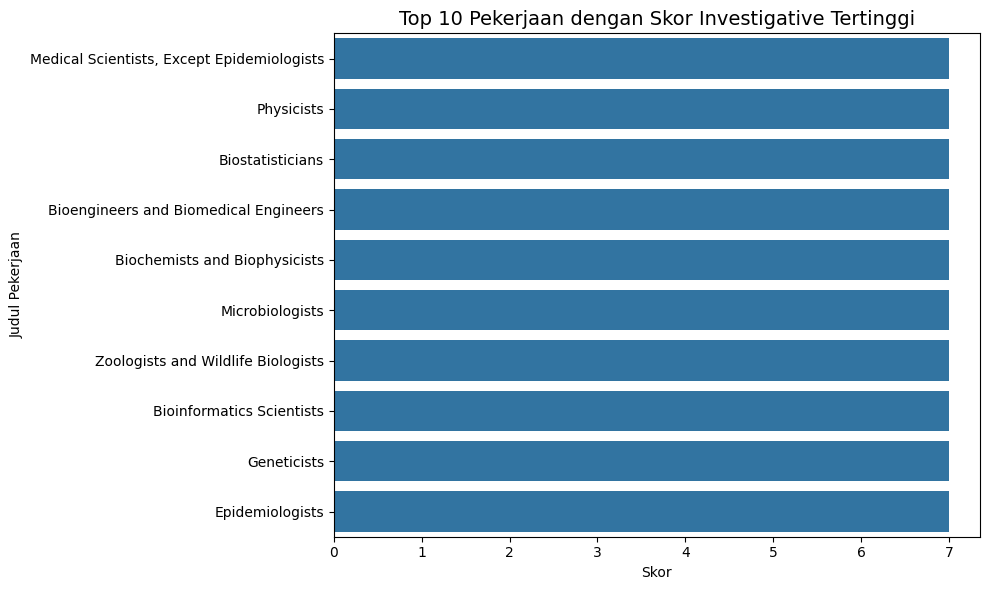

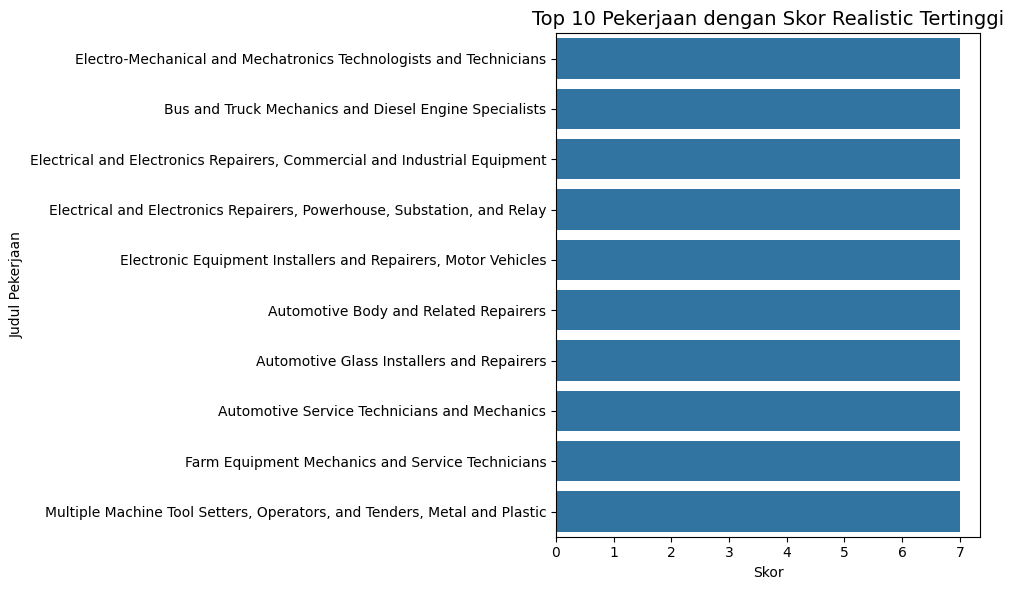

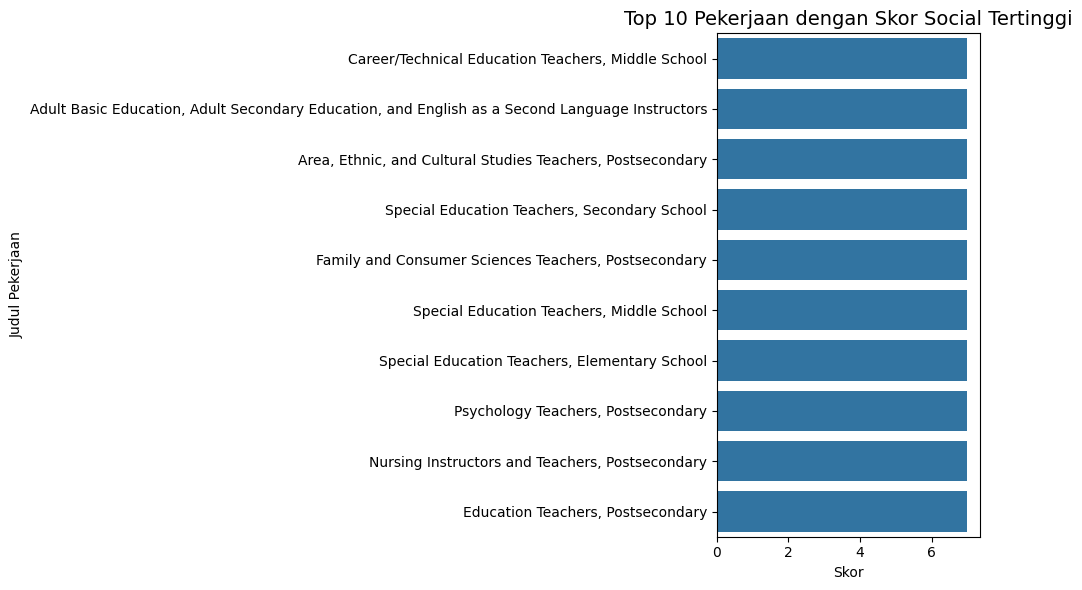

In [9]:
# viasulaisai 10 pekerjaan teratas berdasarkan skor tipe RIASEC

riasec_types = ['Artistic', 'Conventional', 'Enterprising', 'Investigative', 'Realistic', 'Social']

for riasec in riasec_types:
    filtered = riasec_df[riasec_df['Element Name'] == riasec]
    top_jobs = filtered[['Title', 'Data Value']].sort_values(by='Data Value', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_jobs, x='Data Value', y='Title')
    plt.title(f'Top 10 Pekerjaan dengan Skor {riasec} Tertinggi', fontsize=14)
    plt.xlabel('Skor')
    plt.ylabel('Judul Pekerjaan')
    plt.tight_layout()
    plt.show()

In [10]:
#variable occupation 
occupation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   O*NET-SOC Code  1016 non-null   object
 1   Occupation      1016 non-null   object
 2   Job Family      1016 non-null   object
dtypes: object(3)
memory usage: 23.9+ KB


In [11]:
print("Jumlah jenis Job Family unik:", occupation_df['Job Family'].nunique())
print("Jenis-jenis Job Family:", occupation_df['Job Family'].unique())

Jumlah jenis Job Family unik: 23
Jenis-jenis Job Family: ['Business and Financial Operations'
 'Arts, Design, Entertainment, Sports, and Media'
 'Computer and Mathematical' 'Healthcare Practitioners and Technical'
 'Educational Instruction and Library' 'Production' 'Legal' 'Management'
 'Sales and Related' 'Architecture and Engineering'
 'Farming, Fishing, and Forestry' 'Life, Physical, and Social Science'
 'Military Specific' 'Transportation and Material Moving'
 'Installation, Maintenance, and Repair' 'Personal Care and Service'
 'Protective Service' 'Food Preparation and Serving Related'
 'Office and Administrative Support' 'Construction and Extraction'
 'Building and Grounds Cleaning and Maintenance'
 'Community and Social Service' 'Healthcare Support']


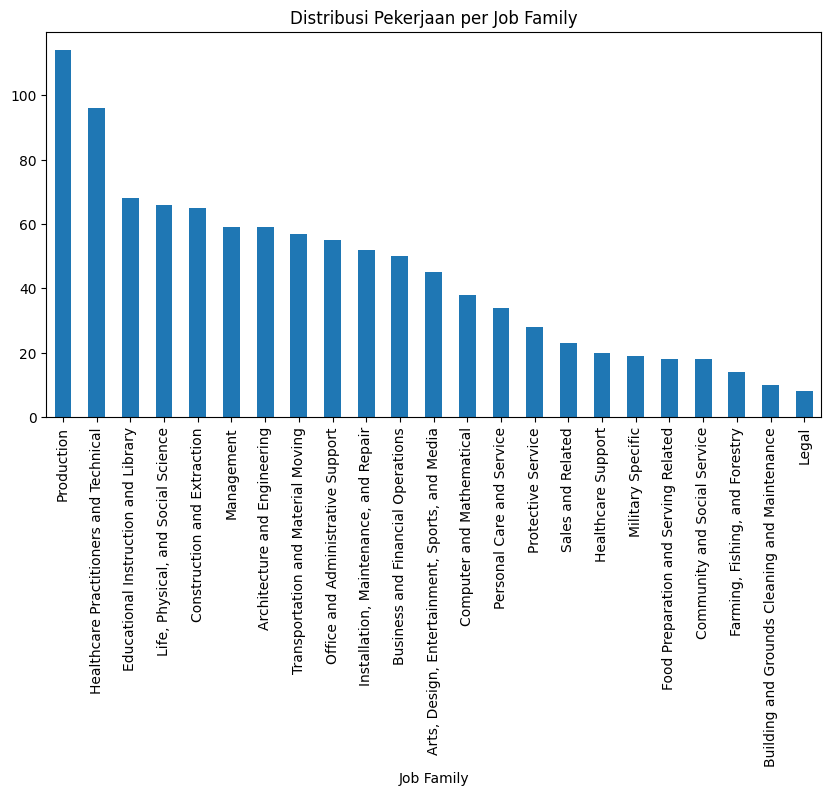

In [12]:
#Distribusi job family

plt.figure(figsize=(10, 5))
occupation_df['Job Family'].value_counts().plot(kind='bar')
plt.title('Distribusi Pekerjaan per Job Family')
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing 


Pivot data RIASEC

mengubah data dari format long(baris per elemen RIASEC) ke format wide(kolom per elemen RIASEC), sehingga setiap pekerjaan mempunyai 6 kolom RIASEC


In [13]:
#Pivot data riasec
df_pivot = riasec_df.pivot_table(
    index=['O*NET-SOC Code', 'Title'],
    columns='Element Name',
    values='Data Value'
).reset_index()
df_pivot

Element Name,O*NET-SOC Code,Title,Artistic,Conventional,Enterprising,First Interest High-Point,Investigative,Realistic,Second Interest High-Point,Social,Third Interest High-Point
0,11-1011.00,Chief Executives,2.08,5.00,6.88,5.0,3.24,1.30,6.0,3.52,0.0
1,11-1011.03,Chief Sustainability Officers,2.48,4.49,6.68,5.0,4.78,2.04,2.0,3.55,6.0
2,11-1021.00,General and Operations Managers,1.31,5.32,6.96,5.0,2.39,2.22,6.0,3.37,0.0
3,11-1031.00,Legislators,2.70,3.62,5.52,5.0,3.35,1.54,4.0,3.69,6.0
4,11-2011.00,Advertising and Promotions Managers,3.85,4.30,7.00,5.0,1.71,1.07,6.0,3.14,3.0
...,...,...,...,...,...,...,...,...,...,...,...
918,53-7071.00,Gas Compressor and Gas Pumping Station Operators,1.00,4.85,1.52,1.0,2.33,6.14,6.0,1.54,0.0
919,53-7072.00,"Pump Operators, Except Wellhead Pumpers",1.00,4.51,1.46,1.0,2.26,6.67,6.0,1.28,0.0
920,53-7073.00,Wellhead Pumpers,1.00,4.36,1.87,1.0,2.41,6.77,6.0,1.07,0.0
921,53-7081.00,Refuse and Recyclable Material Collectors,1.00,4.41,1.55,1.0,1.77,7.00,6.0,1.39,0.0


In [14]:
riasec_df['Element Name'].unique()

array(['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising',
       'Conventional', 'First Interest High-Point',
       'Second Interest High-Point', 'Third Interest High-Point'],
      dtype=object)

#### Menggabungkan data riasec dan occupation 

In [15]:
#Merge data riasec dan data occupation
df_pivot = df_pivot.merge(occupation_df, on='O*NET-SOC Code', how='left')
df_pivot

,O*NET-SOC Code,Title,Artistic,Conventional,Enterprising,First Interest High-Point,Investigative,Realistic,Second Interest High-Point,Social,Third Interest High-Point,Occupation,Job Family
0,11-1011.00,Chief Executives,2.08,5.00,6.88,5.0,3.24,1.30,6.0,3.52,0.0,Chief Executives,Management
1,11-1011.03,Chief Sustainability Officers,2.48,4.49,6.68,5.0,4.78,2.04,2.0,3.55,6.0,Chief Sustainability Officers,Management
2,11-1021.00,General and Operations Managers,1.31,5.32,6.96,5.0,2.39,2.22,6.0,3.37,0.0,General and Operations Managers,Management
3,11-1031.00,Legislators,2.70,3.62,5.52,5.0,3.35,1.54,4.0,3.69,6.0,Legislators,Management
4,11-2011.00,Advertising and Promotions Managers,3.85,4.30,7.00,5.0,1.71,1.07,6.0,3.14,3.0,Advertising and Promotions Managers,Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,53-7071.00,Gas Compressor and Gas Pumping Station Operators,1.00,4.85,1.52,1.0,2.33,6.14,6.0,1.54,0.0,Gas Compressor and Gas Pumping Station Operators,Transportation and Material Moving
919,53-7072.00,"Pump Operators, Except Wellhead Pumpers",1.00,4.51,1.46,1.0,2.26,6.67,6.0,1.28,0.0,"Pump Operators, Except Wellhead Pumpers",Transportation and Material Moving
920,53-7073.00,Wellhead Pumpers,1.00,4.36,1.87,1.0,2.41,6.77,6.0,1.07,0.0,Wellhead Pumpers,Transportation and Material Moving
921,53-7081.00,Refuse and Recyclable Material Collectors,1.00,4.41,1.55,1.0,1.77,7.00,6.0,1.39,0.0,Refuse and Recyclable Material Collectors,Transportation and Material Moving


In [16]:
#Simpan hasil merge
df_pivot.to_csv("Dataset/job_with_family.csv", index=False)

## Data Preparation

In [17]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   O*NET-SOC Code              923 non-null    object 
 1   Title                       923 non-null    object 
 2   Artistic                    923 non-null    float64
 3   Conventional                923 non-null    float64
 4   Enterprising                923 non-null    float64
 5   First Interest High-Point   923 non-null    float64
 6   Investigative               923 non-null    float64
 7   Realistic                   923 non-null    float64
 8   Second Interest High-Point  923 non-null    float64
 9   Social                      923 non-null    float64
 10  Third Interest High-Point   923 non-null    float64
 11  Occupation                  923 non-null    object 
 12  Job Family                  923 non-null    object 
dtypes: float64(9), object(4)
memory usa

In [18]:
print(df_pivot.isnull().sum())

O*NET-SOC Code                0
Title                         0
Artistic                      0
Conventional                  0
Enterprising                  0
First Interest High-Point     0
Investigative                 0
Realistic                     0
Second Interest High-Point    0
Social                        0
Third Interest High-Point     0
Occupation                    0
Job Family                    0
dtype: int64


In [19]:
df_pivot[['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising', 'Conventional']].describe()

,Realistic,Investigative,Artistic,Social,Enterprising,Conventional
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,4.578028,3.365515,1.933239,2.938927,2.820098,4.531820
std,1.924689,1.685251,1.208703,1.743803,1.608613,0.998796
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.660000
25%,2.910000,2.020000,1.000000,1.500000,1.550000,3.730000
50%,4.850000,2.960000,1.490000,2.460000,2.350000,4.440000
75%,6.395000,4.760000,2.340000,3.855000,3.770000,5.175000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


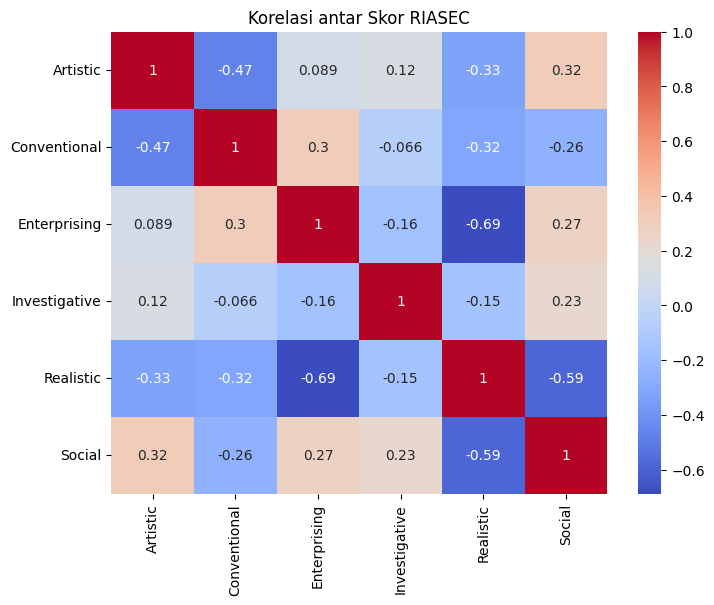

In [20]:
# Heatmap Korelasi RIASEC
plt.figure(figsize=(8, 6))
sns.heatmap(df_pivot[riasec_types].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Skor RIASEC')
plt.show()

Interpretasi Hasil Heatmap Korelasi:
1. Korelasi Positif (warna merah):
- Artistic – Social: 0.32 → Pekerjaan yang tinggi pada "Artistic" cenderung juga tinggi pada "Social".
- Enterprising – Conventional: 0.30 → Pekerjaan yang bersifat memimpin juga cenderung punya struktur dan organisasi yang baik.
- Investigative – Social: 0.23 → Ada hubungan lemah positif antara analitis dan sosial.

2. Korelasi Negatif (warna biru):
- Realistic – Enterprising: -0.69 → Pekerjaan realistis (praktis/manual) sangat berbeda dari pekerjaan enterprising (memimpin/berbisnis).
- Realistic – Social: -0.59 → Pekerjaan realistis juga bertolak belakang dengan pekerjaan sosial.
- Artistic – Conventional: -0.47 → Pekerjaan kreatif sangat berbeda dari yang terstruktur dan rutin.



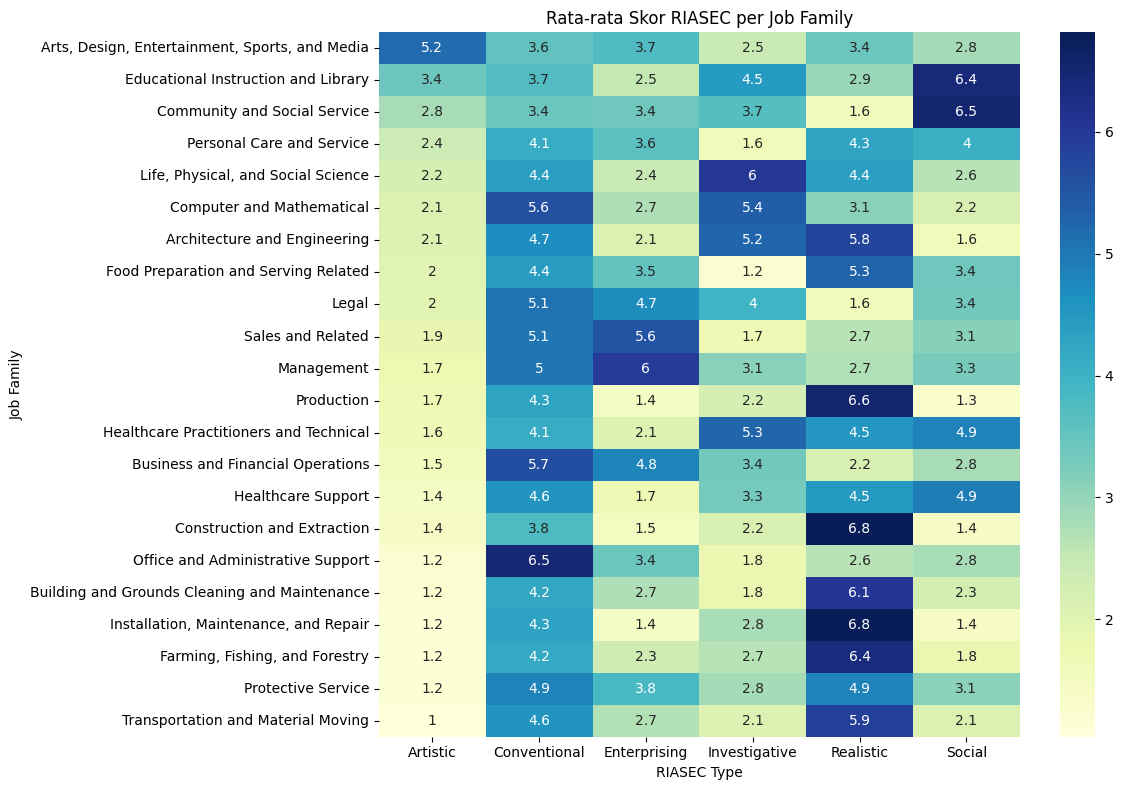

In [21]:
# Rata-rata skor RIASEC per Family
riasec_means = df_pivot.groupby('Job Family')[riasec_types].mean().sort_values(by='Artistic', ascending=False)
plt.figure(figsize=(12, 8))
sns.heatmap(riasec_means, annot=True, cmap='YlGnBu')
plt.title('Rata-rata Skor RIASEC per Job Family')
plt.ylabel('Job Family')
plt.xlabel('RIASEC Type')
plt.tight_layout()
plt.show()


Interpretasi :
Jika seseorang memiliki skor tinggi di:
- Artistic → cocok di "Arts, Design, Entertainment".
- Investigative → cocok di "Life, Physical, and Social Science".
- Realistic → cocok di "Construction", "Installation", atau "Production".
- Social → cocok di "Community and Social Service" atau "Healthcare".

Standardisasi Nilai RIASEC

untuk mengubah nilai-nilai RIASEC ke skala distribusi normal (mean = 0, std = 1)

In [34]:
riasec_types = ['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising', 'Conventional']
df_pivot = df_pivot[['O*NET-SOC Code', 'Title', 'Job Family'] + riasec_types]

scaler = StandardScaler()
riasec_scaled = scaler.fit_transform(df_pivot[riasec_types])

# Simpan scaler
joblib.dump(scaler, "Model/scaler.pkl")

['Model/scaler.pkl']

# Model 


In [ ]:
#Model Embeding
def create_embedding_model(input_dim=6, embedding_dim=16):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(embedding_dim)(x)
    return tf.keras.Model(inputs, outputs)

embedding_model = create_embedding_model()

In [26]:
# Triplet Sampling

def generate_triplets(data, n_triplets=10000):
    triplets = []
    for _ in range(n_triplets):
        anchor_idx = np.random.randint(len(data))
        anchor = data[anchor_idx]
        dists = np.linalg.norm(data - anchor, axis=1)
        positive_pool = np.where(dists < 1.0)[0]
        negative_pool = np.where(dists > 2.0)[0]
        if len(positive_pool) > 1 and len(negative_pool) > 0:
            positive_idx = np.random.choice(positive_pool)
            while positive_idx == anchor_idx:
                positive_idx = np.random.choice(positive_pool)
            negative_idx = np.random.choice(negative_pool)
            triplets.append((anchor, data[positive_idx], data[negative_idx]))
    return triplets

triplets = generate_triplets(riasec_scaled)
anchors = np.array([t[0] for t in triplets])
positives = np.array([t[1] for t in triplets])
negatives = np.array([t[2] for t in triplets])


In [35]:
#  Triplet Loss

def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

In [36]:
#  Triplet Model Training

input_anchor = tf.keras.Input(shape=(6,))
input_positive = tf.keras.Input(shape=(6,))
input_negative = tf.keras.Input(shape=(6,))
embedded_anchor = embedding_model(input_anchor)
embedded_positive = embedding_model(input_positive)
embedded_negative = embedding_model(input_negative)
merged_output = tf.keras.layers.Concatenate()([embedded_anchor, embedded_positive, embedded_negative])

triplet_model = tf.keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)
triplet_model.compile(optimizer='adam', loss=triplet_loss())

history = triplet_model.fit(
    [anchors, positives, negatives],
    np.zeros(len(triplets)),
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - loss: 0.0099 - val_loss: 0.0052
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0111 - val_loss: 0.0025
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0063 - val_loss: 2.1776e-04
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0056 - val_loss: 9.0427e-04
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0071 - val_loss: 2.4604e-04
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0046 - val_loss: 0.0000e+00
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022 - val_loss: 0.0000e+00
Epoch 12/20
121/121 

In [31]:
# Simpan Model Embedding
embedding_model.save("Model/embedding_model.h5")

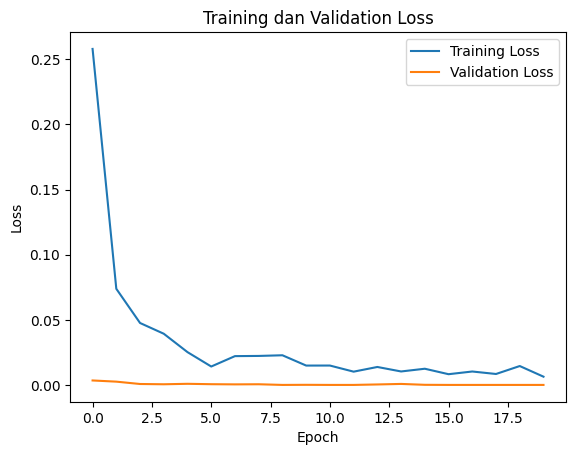

In [32]:
#  Plot Loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
